In [5]:
from data import colorize_image as CI
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# load images
imgs2read = open('preprocessedimages2read', 'r')
allimgs2read = []
for line in imgs2read:
    line = line.strip()
    line = line.split()
    for img in line:
        if '-original' in img:
            img = img.replace('-original.jpg', '')
            allimgs2read.append(img)

# Choose gpu to run the model on
gpu_id = 0

# Initialize colorization class
colorModel = CI.ColorizeImageCaffe(Xd=256)

# Load the model
colorModel.prep_net(gpu_id,'./models/reference_model/deploy_nodist.prototxt','./models/reference_model/model.caffemodel')


ColorizeImageCaffe instantiated
gpu_id = 0, net_path = ./models/reference_model/deploy_nodist.prototxt, model_path = ./models/reference_model/model.caffemodel


0Bwa2J
./preprocessed/0Bwa2J-histo.png
0
0qADtP
./preprocessed/0qADtP-histo.png
1


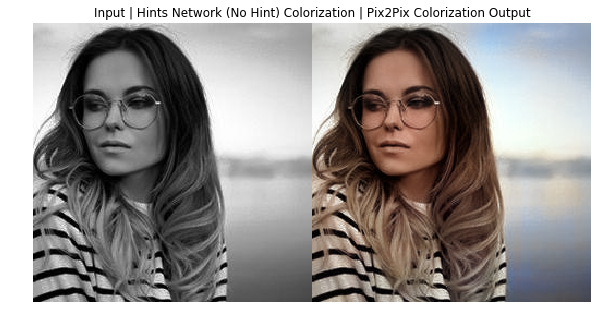

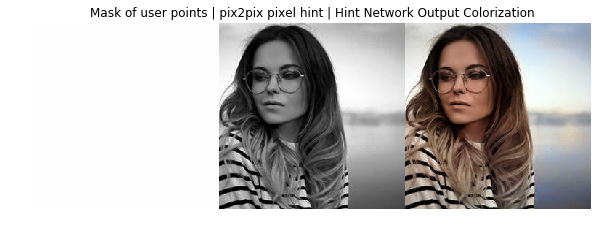

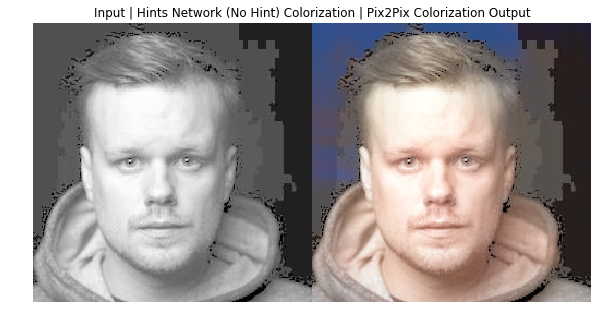

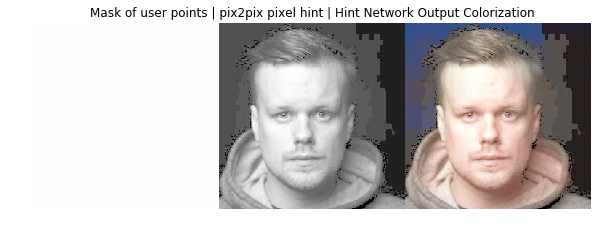

In [7]:
import matplotlib.image as mpimg
from PIL import Image
import cv2

count = 0

def find_pixel(lab, xs_prev, ys_prev):
    l, a, b = 0, 0, 0
    pixel_found = False
    chroma = 0
    x_found, y_found = 0,0
    for x in range(len(lab)):
        for y in range(len(lab[x])):
            pls_continue = False
            if len(xs_prev)!=0 and len(xs_prev)!=0:
                for i in range(len(xs_prev)):
                    if (abs(x-xs_prev[i])/256.0<.1 or abs(y-ys_prev[i])/256.0<.1):
                        pls_continue = True
                        
            if not pls_continue:
                pixel = list(lab[x][y])
                l = pixel[0]
                a = pixel[1]
                b = pixel[2]
                chroma_check = a**2+b**2
                if l>40 and l<85:
                    if chroma_check > chroma:
                        #print(x,y)
                        chroma = chroma_check
                        pixel_found = True
                        x_found, y_found = x, y

    return x_found, y_found 
    
def choose_pixels(input_ab, mask, lab, count):
    xs,ys = [],[]
    x, y = 0, 0
    locs, hints = [],[]
    for i in range(count):
        x, y = find_pixel(lab, xs, ys)
        #print("x and y are", x, y)
        xs.append(x)
        ys.append(y)
    #print(xs, ys)
    for i in range(len(xs)):
        x = xs[i]
        y = ys[i]
        if x==0 and y==0:
            continue
        else:
            pix2pix_output_loc = [x,y]
            pix2pix_output_hint = list(lab[x][y])[1:]
            locs.append(pix2pix_output_loc)
            hints.append(pix2pix_output_hint)
    return locs, hints
        

for img in allimgs2read:
    if count == 11:
        break
    print(img)
    # Load the image
    img_url = './preprocessed/' + img
#     pix2pix_output = Image.open(img_url + '-original.png')
    print(img_url+'-histo.png')
    colorModel.load_image(img_url+'-histo.jpg') # load an image

    mask = np.zeros((1,256,256)) # giving no user points, so mask is all 0's
    input_ab = np.zeros((2,256,256)) # ab values of user points, default to 0 for no input
    img_out = colorModel.net_forward(input_ab,mask) # run model, returns 256x256 image

    img_gray_fullres = colorModel.get_img_gray_fullres() # get grayscale image at fullresolution
    img_out_fullres = colorModel.get_img_fullres() # get image at full resolution


    
    # show result
    plt.figure(figsize=(10,6))
    plt.imshow(np.concatenate((img_gray_fullres,img_out_fullres),axis=1)); plt.axis('off');
    plt.title('Input | Hints Network (No Hint) Colorization | Pix2Pix Colorization Output')
    def put_point(input_ab,mask,loc,p,val):
        # input_ab    2x256x256    current user ab input (will be updated)
        # mask        1x256x256    binary mask of current user input (will be updated)
        # loc         2 tuple      (h,w) of where to put the user input
        # p           scalar       half-patch size
        # val         2 tuple      (a,b) value of user input
        input_ab[:,loc[0]-p:loc[0]+p+1,loc[1]-p:loc[1]+p+1] = np.array(val)[:,np.newaxis,np.newaxis]
        mask[:,loc[0]-p:loc[0]+p+1,loc[1]-p:loc[1]+p+1] = 1
        return (input_ab,mask)

    # get random pixel hint from colored output of pix2pix
#     from skimage import io, color
#     import random
#     rgb = io.imread(img_url+'-outputs.png')
#     lab = color.rgb2lab(rgb)
    


#     if pixel_found == False:
#         print("sad bois")
#         x,y = random.randint(0,len(lab)-1), random.randint(0,len(lab[0])-1)
#         random_pix2pix_output_loc = [x,y]
#         random_pix2pix_output_hint = list(lab[x][y])[1:]
#     else:
#         print("found it boi")
    #print(random_pix2pix_output_loc,random_pix2pix_output_hint)

    # initialize with no user inputs
    input_ab = np.zeros((2,256,256))
    mask = np.zeros((1,256,256))

#     locs, hints = choose_pixels(input_ab, mask, lab, 3)
    # add a random point to the image
    #(input_ab,mask) = put_point(input_ab,mask,random_pix2pix_output_loc,3,random_pix2pix_output_hint)
    
#     for i in range(len(locs)):
#         (input_ab,mask) = put_point(input_ab,mask,locs[i],1,hints[i])
        
#     x,y = random.randint(0,len(lab)-1), random.randint(0,len(lab[0])-1)
#     random_pix2pix_output_loc2 = [x,y]
#     random_pix2pix_output_hint2 = list(lab[x][y])[1:]
#     (input_ab,mask) = put_point(input_ab,mask,random_pix2pix_output_loc2,3,random_pix2pix_output_hint2)

    # call forward
    img_out = colorModel.net_forward(input_ab,mask)

    # get mask, input image, and result in full resolution
    mask_fullres = colorModel.get_img_mask_fullres() # get input mask in full res
    img_in_fullres = colorModel.get_input_img_fullres() # get input image in full res
    img_out_fullres = colorModel.get_img_fullres() # get image at full resolution

    # show user input, along with output
    plt.figure(figsize=(10,6))
    plt.imshow(np.concatenate((mask_fullres,img_in_fullres,img_out_fullres),axis=1));
    plt.title('Mask of user points | pix2pix pixel hint | Hint Network Output Colorization')
    plt.axis('off');

#     TO SAVE
#     result = Image.fromarray(img_out_fullres, mode='RGB')
#     result.save(img_url + "-5hints.png")
    print(count)
    count+=1
    
plt.show()

0Bwa2J
./preprocessed/0Bwa2J-adapt.png
0
0qADtP
./preprocessed/0qADtP-adapt.png
1


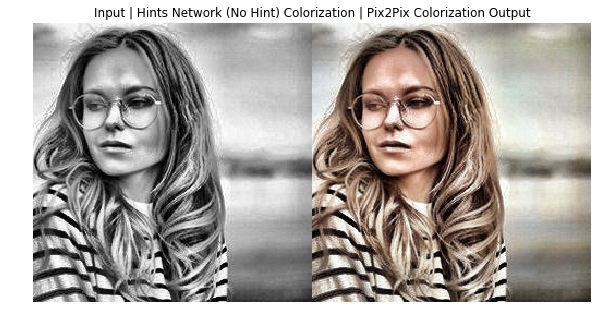

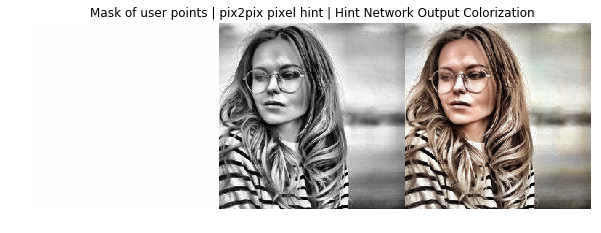

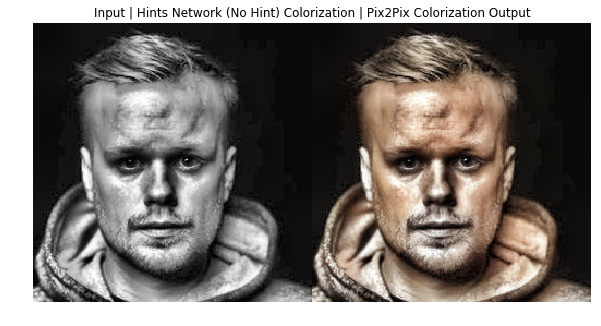

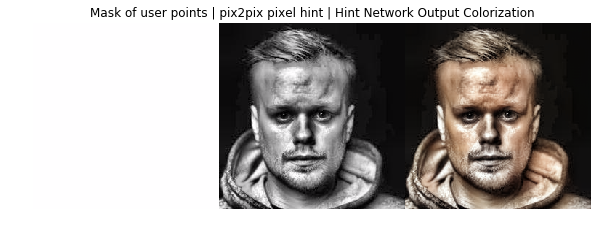

In [8]:
import matplotlib.image as mpimg
from PIL import Image
import cv2

count = 0

def find_pixel(lab, xs_prev, ys_prev):
    l, a, b = 0, 0, 0
    pixel_found = False
    chroma = 0
    x_found, y_found = 0,0
    for x in range(len(lab)):
        for y in range(len(lab[x])):
            pls_continue = False
            if len(xs_prev)!=0 and len(xs_prev)!=0:
                for i in range(len(xs_prev)):
                    if (abs(x-xs_prev[i])/256.0<.1 or abs(y-ys_prev[i])/256.0<.1):
                        pls_continue = True
                        
            if not pls_continue:
                pixel = list(lab[x][y])
                l = pixel[0]
                a = pixel[1]
                b = pixel[2]
                chroma_check = a**2+b**2
                if l>40 and l<85:
                    if chroma_check > chroma:
                        #print(x,y)
                        chroma = chroma_check
                        pixel_found = True
                        x_found, y_found = x, y

    return x_found, y_found 
    
def choose_pixels(input_ab, mask, lab, count):
    xs,ys = [],[]
    x, y = 0, 0
    locs, hints = [],[]
    for i in range(count):
        x, y = find_pixel(lab, xs, ys)
        #print("x and y are", x, y)
        xs.append(x)
        ys.append(y)
    #print(xs, ys)
    for i in range(len(xs)):
        x = xs[i]
        y = ys[i]
        if x==0 and y==0:
            continue
        else:
            pix2pix_output_loc = [x,y]
            pix2pix_output_hint = list(lab[x][y])[1:]
            locs.append(pix2pix_output_loc)
            hints.append(pix2pix_output_hint)
    return locs, hints
        

for img in allimgs2read:
    if count == 11:
        break
    print(img)
    # Load the image
    img_url = './preprocessed/' + img
#     pix2pix_output = Image.open(img_url + '-original.png')
    print(img_url+'-adapt.png')
    colorModel.load_image(img_url+'-adapt.jpg') # load an image

    mask = np.zeros((1,256,256)) # giving no user points, so mask is all 0's
    input_ab = np.zeros((2,256,256)) # ab values of user points, default to 0 for no input
    img_out = colorModel.net_forward(input_ab,mask) # run model, returns 256x256 image

    img_gray_fullres = colorModel.get_img_gray_fullres() # get grayscale image at fullresolution
    img_out_fullres = colorModel.get_img_fullres() # get image at full resolution


    
    # show result
    plt.figure(figsize=(10,6))
    plt.imshow(np.concatenate((img_gray_fullres,img_out_fullres),axis=1)); plt.axis('off');
    plt.title('Input | Hints Network (No Hint) Colorization | Pix2Pix Colorization Output')
    def put_point(input_ab,mask,loc,p,val):
        # input_ab    2x256x256    current user ab input (will be updated)
        # mask        1x256x256    binary mask of current user input (will be updated)
        # loc         2 tuple      (h,w) of where to put the user input
        # p           scalar       half-patch size
        # val         2 tuple      (a,b) value of user input
        input_ab[:,loc[0]-p:loc[0]+p+1,loc[1]-p:loc[1]+p+1] = np.array(val)[:,np.newaxis,np.newaxis]
        mask[:,loc[0]-p:loc[0]+p+1,loc[1]-p:loc[1]+p+1] = 1
        return (input_ab,mask)

    # get random pixel hint from colored output of pix2pix
#     from skimage import io, color
#     import random
#     rgb = io.imread(img_url+'-outputs.png')
#     lab = color.rgb2lab(rgb)
    


#     if pixel_found == False:
#         print("sad bois")
#         x,y = random.randint(0,len(lab)-1), random.randint(0,len(lab[0])-1)
#         random_pix2pix_output_loc = [x,y]
#         random_pix2pix_output_hint = list(lab[x][y])[1:]
#     else:
#         print("found it boi")
    #print(random_pix2pix_output_loc,random_pix2pix_output_hint)

    # initialize with no user inputs
    input_ab = np.zeros((2,256,256))
    mask = np.zeros((1,256,256))

#     locs, hints = choose_pixels(input_ab, mask, lab, 3)
    # add a random point to the image
    #(input_ab,mask) = put_point(input_ab,mask,random_pix2pix_output_loc,3,random_pix2pix_output_hint)
    
#     for i in range(len(locs)):
#         (input_ab,mask) = put_point(input_ab,mask,locs[i],1,hints[i])
        
#     x,y = random.randint(0,len(lab)-1), random.randint(0,len(lab[0])-1)
#     random_pix2pix_output_loc2 = [x,y]
#     random_pix2pix_output_hint2 = list(lab[x][y])[1:]
#     (input_ab,mask) = put_point(input_ab,mask,random_pix2pix_output_loc2,3,random_pix2pix_output_hint2)

    # call forward
    img_out = colorModel.net_forward(input_ab,mask)

    # get mask, input image, and result in full resolution
    mask_fullres = colorModel.get_img_mask_fullres() # get input mask in full res
    img_in_fullres = colorModel.get_input_img_fullres() # get input image in full res
    img_out_fullres = colorModel.get_img_fullres() # get image at full resolution

    # show user input, along with output
    plt.figure(figsize=(10,6))
    plt.imshow(np.concatenate((mask_fullres,img_in_fullres,img_out_fullres),axis=1));
    plt.title('Mask of user points | pix2pix pixel hint | Hint Network Output Colorization')
    plt.axis('off');

#     TO SAVE
#     result = Image.fromarray(img_out_fullres, mode='RGB')
#     result.save(img_url + "-5hints.png")
    print(count)
    count+=1
    
plt.show()

0Bwa2J
./preprocessed/0Bwa2J-contrast.png
0
0qADtP
./preprocessed/0qADtP-contrast.png
1


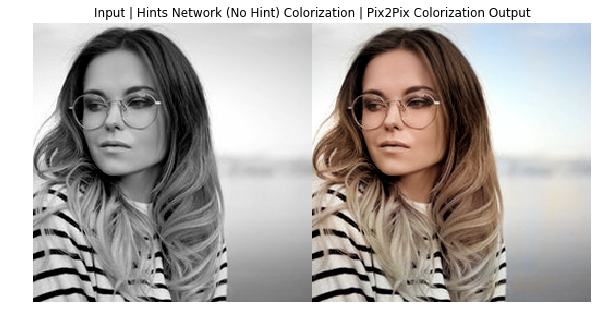

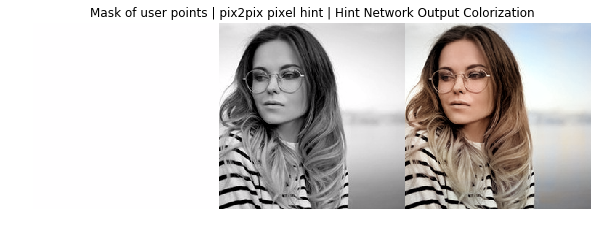

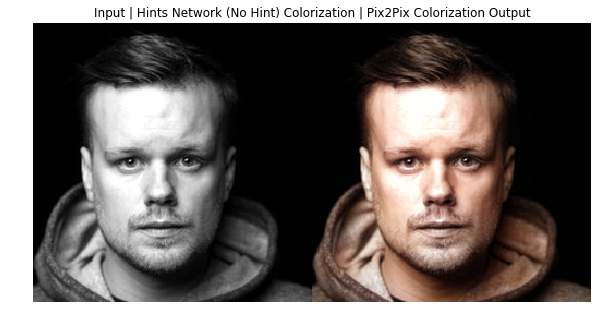

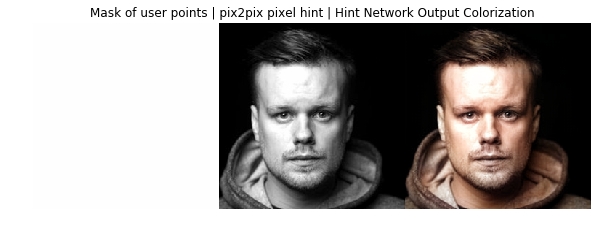

In [13]:
import matplotlib.image as mpimg
from PIL import Image
import cv2

count = 0

def find_pixel(lab, xs_prev, ys_prev):
    l, a, b = 0, 0, 0
    pixel_found = False
    chroma = 0
    x_found, y_found = 0,0
    for x in range(len(lab)):
        for y in range(len(lab[x])):
            pls_continue = False
            if len(xs_prev)!=0 and len(xs_prev)!=0:
                for i in range(len(xs_prev)):
                    if (abs(x-xs_prev[i])/256.0<.1 or abs(y-ys_prev[i])/256.0<.1):
                        pls_continue = True
                        
            if not pls_continue:
                pixel = list(lab[x][y])
                l = pixel[0]
                a = pixel[1]
                b = pixel[2]
                chroma_check = a**2+b**2
                if l>40 and l<85:
                    if chroma_check > chroma:
                        #print(x,y)
                        chroma = chroma_check
                        pixel_found = True
                        x_found, y_found = x, y

    return x_found, y_found 
    
def choose_pixels(input_ab, mask, lab, count):
    xs,ys = [],[]
    x, y = 0, 0
    locs, hints = [],[]
    for i in range(count):
        x, y = find_pixel(lab, xs, ys)
        #print("x and y are", x, y)
        xs.append(x)
        ys.append(y)
    #print(xs, ys)
    for i in range(len(xs)):
        x = xs[i]
        y = ys[i]
        if x==0 and y==0:
            continue
        else:
            pix2pix_output_loc = [x,y]
            pix2pix_output_hint = list(lab[x][y])[1:]
            locs.append(pix2pix_output_loc)
            hints.append(pix2pix_output_hint)
    return locs, hints
        

for img in allimgs2read:
    if count == 11:
        break
    print(img)
    # Load the image
    img_url = './preprocessed/' + img
#     pix2pix_output = Image.open(img_url + '-original.png')
    print(img_url+'-contrast.png')
    colorModel.load_image(img_url+'-contrast.jpg') # load an image

    mask = np.zeros((1,256,256)) # giving no user points, so mask is all 0's
    input_ab = np.zeros((2,256,256)) # ab values of user points, default to 0 for no input
    img_out = colorModel.net_forward(input_ab,mask) # run model, returns 256x256 image

    img_gray_fullres = colorModel.get_img_gray_fullres() # get grayscale image at fullresolution
    img_out_fullres = colorModel.get_img_fullres() # get image at full resolution


    
    # show result
    plt.figure(figsize=(10,6))
    plt.imshow(np.concatenate((img_gray_fullres,img_out_fullres),axis=1)); plt.axis('off');
    plt.title('Input | Hints Network (No Hint) Colorization | Pix2Pix Colorization Output')
    def put_point(input_ab,mask,loc,p,val):
        # input_ab    2x256x256    current user ab input (will be updated)
        # mask        1x256x256    binary mask of current user input (will be updated)
        # loc         2 tuple      (h,w) of where to put the user input
        # p           scalar       half-patch size
        # val         2 tuple      (a,b) value of user input
        input_ab[:,loc[0]-p:loc[0]+p+1,loc[1]-p:loc[1]+p+1] = np.array(val)[:,np.newaxis,np.newaxis]
        mask[:,loc[0]-p:loc[0]+p+1,loc[1]-p:loc[1]+p+1] = 1
        return (input_ab,mask)

    # get random pixel hint from colored output of pix2pix
#     from skimage import io, color
#     import random
#     rgb = io.imread(img_url+'-outputs.png')
#     lab = color.rgb2lab(rgb)
    


#     if pixel_found == False:
#         print("sad bois")
#         x,y = random.randint(0,len(lab)-1), random.randint(0,len(lab[0])-1)
#         random_pix2pix_output_loc = [x,y]
#         random_pix2pix_output_hint = list(lab[x][y])[1:]
#     else:
#         print("found it boi")
    #print(random_pix2pix_output_loc,random_pix2pix_output_hint)

    # initialize with no user inputs
    input_ab = np.zeros((2,256,256))
    mask = np.zeros((1,256,256))

#     locs, hints = choose_pixels(input_ab, mask, lab, 3)
    # add a random point to the image
    #(input_ab,mask) = put_point(input_ab,mask,random_pix2pix_output_loc,3,random_pix2pix_output_hint)
    
#     for i in range(len(locs)):
#         (input_ab,mask) = put_point(input_ab,mask,locs[i],1,hints[i])
        
#     x,y = random.randint(0,len(lab)-1), random.randint(0,len(lab[0])-1)
#     random_pix2pix_output_loc2 = [x,y]
#     random_pix2pix_output_hint2 = list(lab[x][y])[1:]
#     (input_ab,mask) = put_point(input_ab,mask,random_pix2pix_output_loc2,3,random_pix2pix_output_hint2)

    # call forward
    img_out = colorModel.net_forward(input_ab,mask)

    # get mask, input image, and result in full resolution
    mask_fullres = colorModel.get_img_mask_fullres() # get input mask in full res
    img_in_fullres = colorModel.get_input_img_fullres() # get input image in full res
    img_out_fullres = colorModel.get_img_fullres() # get image at full resolution

    # show user input, along with output
    plt.figure(figsize=(10,6))
    plt.imshow(np.concatenate((mask_fullres,img_in_fullres,img_out_fullres),axis=1));
    plt.title('Mask of user points | pix2pix pixel hint | Hint Network Output Colorization')
    plt.axis('off');

#     TO SAVE
#     result = Image.fromarray(img_out_fullres, mode='RGB')
#     result.save(img_url + "-5hints.png")
    print(count)
    count+=1
    
plt.show()

0Bwa2J
./preprocessed/0Bwa2J-original.png
0
0qADtP
./preprocessed/0qADtP-original.png
1


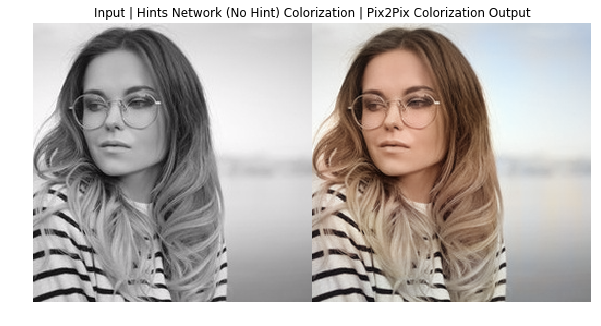

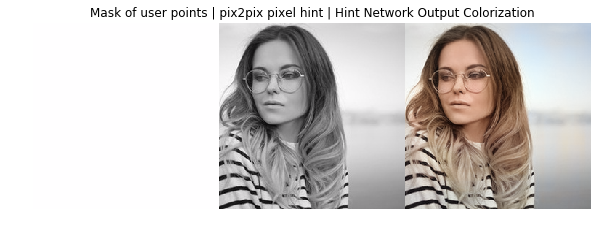

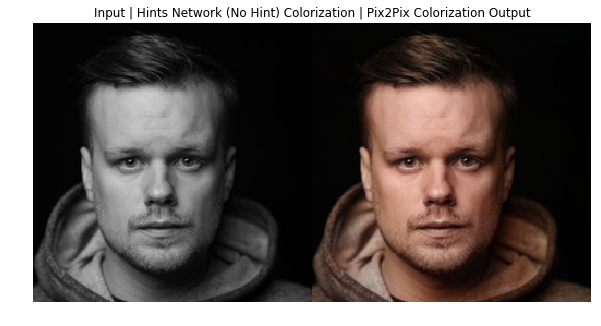

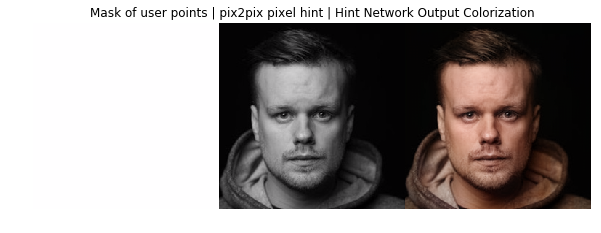

In [12]:
import matplotlib.image as mpimg
from PIL import Image
import cv2

count = 0

def find_pixel(lab, xs_prev, ys_prev):
    l, a, b = 0, 0, 0
    pixel_found = False
    chroma = 0
    x_found, y_found = 0,0
    for x in range(len(lab)):
        for y in range(len(lab[x])):
            pls_continue = False
            if len(xs_prev)!=0 and len(xs_prev)!=0:
                for i in range(len(xs_prev)):
                    if (abs(x-xs_prev[i])/256.0<.1 or abs(y-ys_prev[i])/256.0<.1):
                        pls_continue = True
                        
            if not pls_continue:
                pixel = list(lab[x][y])
                l = pixel[0]
                a = pixel[1]
                b = pixel[2]
                chroma_check = a**2+b**2
                if l>40 and l<85:
                    if chroma_check > chroma:
                        #print(x,y)
                        chroma = chroma_check
                        pixel_found = True
                        x_found, y_found = x, y

    return x_found, y_found 
    
def choose_pixels(input_ab, mask, lab, count):
    xs,ys = [],[]
    x, y = 0, 0
    locs, hints = [],[]
    for i in range(count):
        x, y = find_pixel(lab, xs, ys)
        #print("x and y are", x, y)
        xs.append(x)
        ys.append(y)
    #print(xs, ys)
    for i in range(len(xs)):
        x = xs[i]
        y = ys[i]
        if x==0 and y==0:
            continue
        else:
            pix2pix_output_loc = [x,y]
            pix2pix_output_hint = list(lab[x][y])[1:]
            locs.append(pix2pix_output_loc)
            hints.append(pix2pix_output_hint)
    return locs, hints
        

for img in allimgs2read:
    if count == 11:
        break
    print(img)
    # Load the image
    img_url = './preprocessed/' + img
#     pix2pix_output = Image.open(img_url + '-original.png')
    print(img_url+'-original.png')
    colorModel.load_image(img_url+'-original.jpg') # load an image

    mask = np.zeros((1,256,256)) # giving no user points, so mask is all 0's
    input_ab = np.zeros((2,256,256)) # ab values of user points, default to 0 for no input
    img_out = colorModel.net_forward(input_ab,mask) # run model, returns 256x256 image

    img_gray_fullres = colorModel.get_img_gray_fullres() # get grayscale image at fullresolution
    img_out_fullres = colorModel.get_img_fullres() # get image at full resolution


    
    # show result
    plt.figure(figsize=(10,6))
    plt.imshow(np.concatenate((img_gray_fullres,img_out_fullres),axis=1)); plt.axis('off');
    plt.title('Input | Hints Network (No Hint) Colorization | Pix2Pix Colorization Output')
    def put_point(input_ab,mask,loc,p,val):
        # input_ab    2x256x256    current user ab input (will be updated)
        # mask        1x256x256    binary mask of current user input (will be updated)
        # loc         2 tuple      (h,w) of where to put the user input
        # p           scalar       half-patch size
        # val         2 tuple      (a,b) value of user input
        input_ab[:,loc[0]-p:loc[0]+p+1,loc[1]-p:loc[1]+p+1] = np.array(val)[:,np.newaxis,np.newaxis]
        mask[:,loc[0]-p:loc[0]+p+1,loc[1]-p:loc[1]+p+1] = 1
        return (input_ab,mask)

    # get random pixel hint from colored output of pix2pix
#     from skimage import io, color
#     import random
#     rgb = io.imread(img_url+'-outputs.png')
#     lab = color.rgb2lab(rgb)
    


#     if pixel_found == False:
#         print("sad bois")
#         x,y = random.randint(0,len(lab)-1), random.randint(0,len(lab[0])-1)
#         random_pix2pix_output_loc = [x,y]
#         random_pix2pix_output_hint = list(lab[x][y])[1:]
#     else:
#         print("found it boi")
    #print(random_pix2pix_output_loc,random_pix2pix_output_hint)

    # initialize with no user inputs
    input_ab = np.zeros((2,256,256))
    mask = np.zeros((1,256,256))

#     locs, hints = choose_pixels(input_ab, mask, lab, 3)
    # add a random point to the image
    #(input_ab,mask) = put_point(input_ab,mask,random_pix2pix_output_loc,3,random_pix2pix_output_hint)
    
#     for i in range(len(locs)):
#         (input_ab,mask) = put_point(input_ab,mask,locs[i],1,hints[i])
        
#     x,y = random.randint(0,len(lab)-1), random.randint(0,len(lab[0])-1)
#     random_pix2pix_output_loc2 = [x,y]
#     random_pix2pix_output_hint2 = list(lab[x][y])[1:]
#     (input_ab,mask) = put_point(input_ab,mask,random_pix2pix_output_loc2,3,random_pix2pix_output_hint2)

    # call forward
    img_out = colorModel.net_forward(input_ab,mask)

    # get mask, input image, and result in full resolution
    mask_fullres = colorModel.get_img_mask_fullres() # get input mask in full res
    img_in_fullres = colorModel.get_input_img_fullres() # get input image in full res
    img_out_fullres = colorModel.get_img_fullres() # get image at full resolution

    # show user input, along with output
    plt.figure(figsize=(10,6))
    plt.imshow(np.concatenate((mask_fullres,img_in_fullres,img_out_fullres),axis=1));
    plt.title('Mask of user points | pix2pix pixel hint | Hint Network Output Colorization')
    plt.axis('off');

#     TO SAVE
#     result = Image.fromarray(img_out_fullres, mode='RGB')
#     result.save(img_url + "-5hints.png")
    print(count)
    count+=1
    
plt.show()